In [2]:
from src.PreProcess import getDegreeSequences
import networkx as nx
import pandas as pd
from src.struc2vec import struc2vec
# from gensim.models import Word2Vec
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# from src.GraphAlgorithms import GraphAlgorithms as ga

In [3]:
df = pd.read_excel("src/UN_full.xlsx")

In [4]:
edgelist = [(origin, destination, {"weight":weight}) for origin, destination, weight in df[["origin","destination","weight_scaled"]].values]

In [5]:
G_D = nx.DiGraph(edgelist)
# G_UD = nx.Graph(edgelist)

In [6]:
# Let's start by getting the adjacency matrix
A = nx.adjacency_matrix(G_D).toarray()

In [7]:
for i in range(len(A)):
    A[i,:] /= A[i,:].sum()

In [8]:
# For convenience, let's make it into a pandas dataframe
df = pd.DataFrame(A).stack().reset_index()
df.columns = ("source", "target", "weight")
df = df[df["weight"] > 0]

In [9]:
indexNodes = {i: node for i, node in enumerate(G_D.nodes())}

In [11]:
quat25 = df["weight"].describe()["25%"]
quat50 = df["weight"].describe()["50%"]
quat75 = df["weight"].describe()["75%"]

print(quat25,quat50,quat75)

0.000171368592421224 0.0013355643910900972 0.009280984410031808


In [14]:
removeEdgesDict = {}
for (perc, lim) in [("25",quat25), ("50", quat50), ("75",quat75)]:
    removeEdges = [(indexNodes[int(origin)], indexNodes[int(destination)]) for [origin, destination, weight] in df[df["weight"]<lim].values]
    removeEdgesDict[perc] = removeEdges

In [15]:
for perc, list in removeEdgesDict.items():
    print(perc, len(list))

25 2074
50 4148
75 6222


In [17]:
G_D25 = G_D.copy()
G_D50 = G_D.copy()
G_D75 = G_D.copy()

In [18]:
for (perc, graph) in [("25",G_D25), ("50", G_D50), ("75", G_D75)]:
    edges = removeEdgesDict[perc]
    for (origin, destination) in edges:
        graph.remove_edge(origin, destination)

In [24]:
weights = np.array([edge[2]["weight"] for edge in G_D75.edges(data=True)])

In [25]:
def scale_x(x):
    min_weight = np.min(weights)
    max_weight = np.max(weights)
    min_scale = 0.1
    max_scale = 5
    return (((max_scale-min_scale)*(x-min_weight))/(max_weight-min_weight))+min_scale

In [26]:
weights_scaled = [scale_x(w) for w in weights]

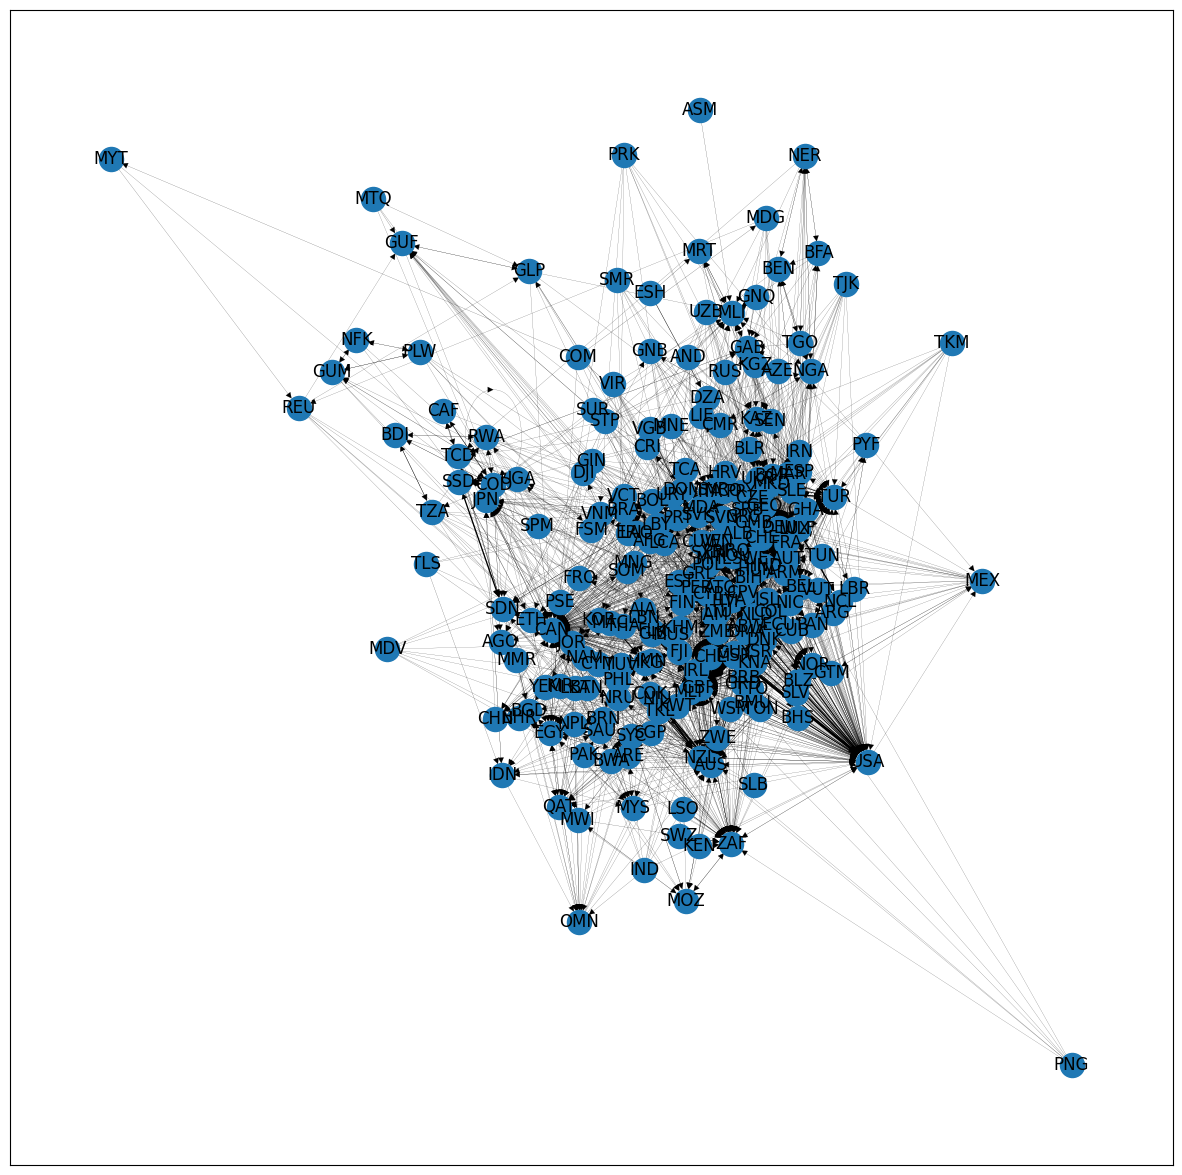

In [28]:
fig, ax = plt.subplots(figsize=(15,15))

nx.draw_networkx(G_D75, width=weights_scaled)

In [29]:
G_UD25 = nx.Graph(G_D25)
G_UD50 = nx.Graph(G_D50)
G_UD75 = nx.Graph(G_D75)

In [30]:
s2vG25 = struc2vec(G_D25)
s2vG50 = struc2vec(G_D50)
s2vG75 = struc2vec(G_D75)

In [31]:
for (perc, cur_s2vG) in [("25", s2vG25), ("50", s2vG50), ("75", s2vG75)]:
    cur_s2vG.getMultiLevelGraph()
    for i, G in cur_s2vG.G_ML.items():
        nx.write_gexf(G, f"GML/{perc}/{i}.gexf")


In [83]:
walks = s2vG.getRandomWalks(number_of_walks = 1000, walk_length=40)

In [84]:
model = Word2Vec(walks, vector_size=75)

In [85]:
embeddings = {node: model.wv[node] for node in s2vG.nodes}

In [86]:
X = np.array(list(embeddings.values()))

In [87]:
pca = PCA(n_components=3)
X_transform = pca.fit_transform(X)

In [88]:
node_embeddings = {}
for node, embedding in enumerate(X_transform):
    emb_list = list(embedding)
    index = emb_list.index(max(emb_list))
    node_embeddings[node] = index

In [89]:
cmap = {0:"green",1:"yellow", 2:"red"}
nodecolors = [cmap[v] for k,v in node_embeddings.items()]

In [ ]:
# Change to scaling instead!
weights = [min(edge[2]["weight"],3) for edge in s2vG.G_D.edges(data=True)]

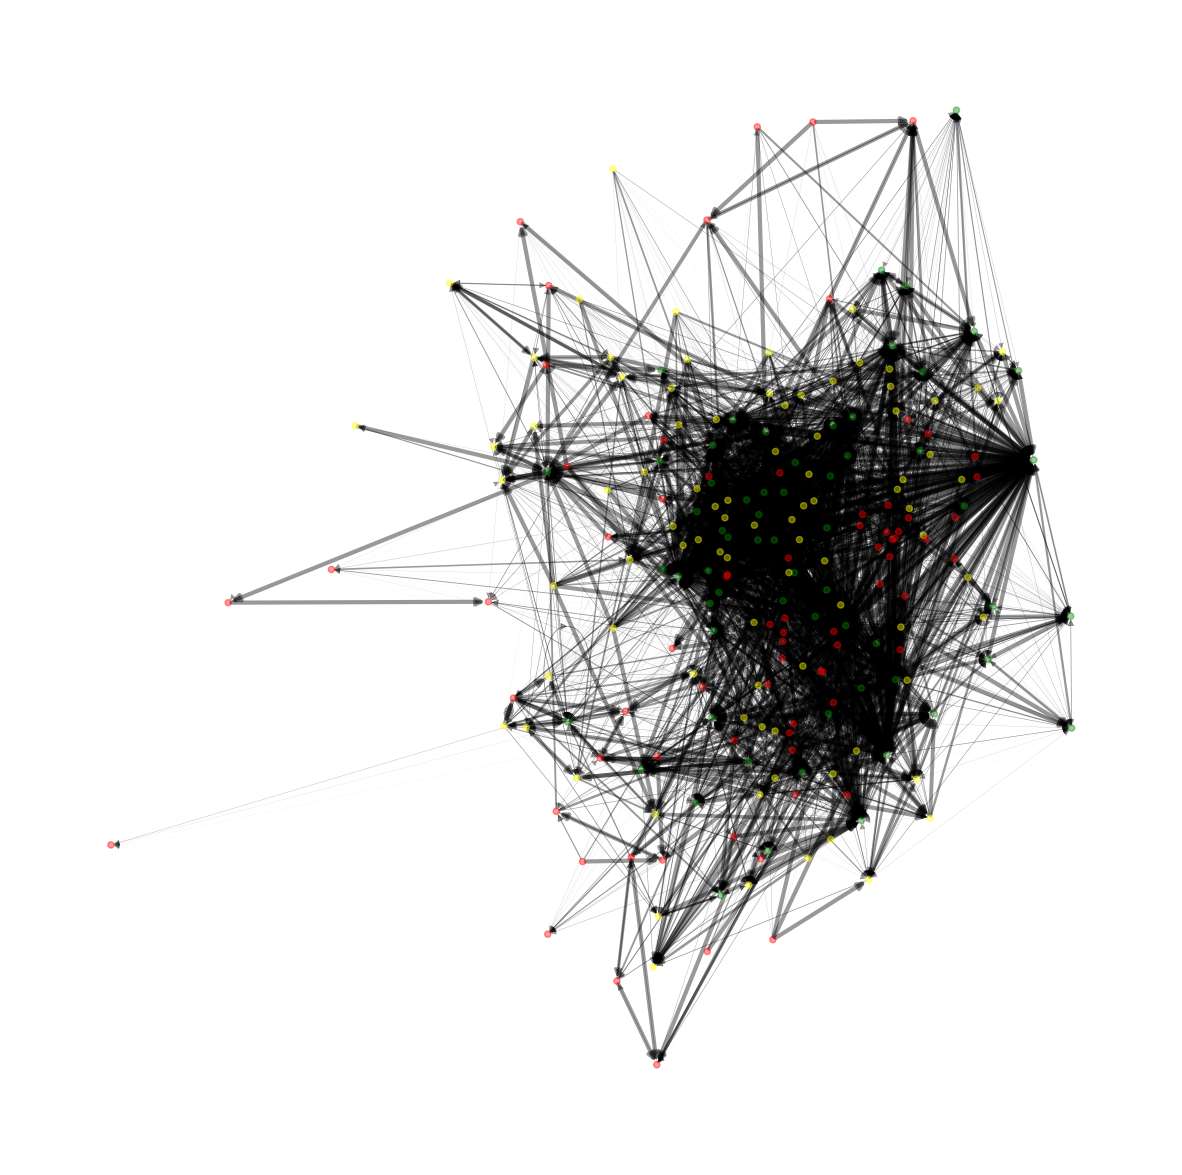

In [91]:
fig, ax = plt.subplots(figsize=(15,15))

nx.draw_spring(s2vG.G_D, with_labels=False, node_color=nodecolors, width = weights, node_size=20, alpha=0.4)